# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                      
Sample_085  A0A087WTP3;C9JSZ1;E9PEB5;M0QXW7;M0QYH3;M0R0I5;Q92945;Q96AE4;Q96AE4-2   18.791
Sample_087  Q16610                                                                 18.572
Sample_084  A0A087X1T7;E7EX88;H0YM81;P16112;P16112-2                               14.976
Sample_070  P45877                                                                 17.611
Sample_004  C9J712;P35080                                                          14.993
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups                                                           
Sample_180  E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3                                      11.210
Sample_025  P30479;Q04826                                                               14.307
Sample_019  H0Y6Q1;O75354;O75354-2;O75354-3;Q5QPI7;Q5QPI9;Q5QPJ3;Q5QPJ4;Q5QPJ6;Q5QPJ7   13.089
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.901
            A0A075B6Q5                 13.629
            A0A075B6R2                 12.094
            A0A075B6S5                 13.632
            A0A087WSY4                 13.067
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.571
            Q9UI40;Q9UI40-2            12.912
            Q9UIW2                     12.236
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.461
            Q9UP79                     11.843
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,10.932,15.050,16.842,19.863,13.846,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,13.934,19.067,...,15.528,15.576,13.082,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.448,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,13.177,17.705,17.039,14.131,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.101,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,10.921,15.345,17.084,18.708,14.249,19.433,9.977,10.032
Sample_207,15.739,16.877,15.469,16.898,12.296,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.394,12.848,13.773,13.172,13.846,12.606,13.284,13.856,12.795,12.581
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,14.043,19.067,16.127,...,12.574,13.154,13.244,13.656,12.460,11.841,13.702,13.670,13.630,11.570
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.371,12.568,12.427,11.923,12.996,14.133,12.386,13.320,12.202,14.150
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.652,12.710,13.344,12.087,13.357,13.994,14.527,12.505,13.021,12.568
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.871,12.364,13.629,12.287,13.510,13.588,14.558,12.431,12.738,12.234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.810,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 173.57it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

100%|██████████| 2/2 [00:00<00:00,  5.07it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.18it/s]

100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.17it/s]

100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.58it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.89it/s]

 80%|████████  | 4/5 [00:00<00:00,  5.19it/s]

100%|██████████| 5/5 [00:00<00:00,  4.85it/s]

100%|██████████| 5/5 [00:00<00:00,  5.26it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.31it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.65it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.99it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.76it/s]

100%|██████████| 6/6 [00:01<00:00,  4.31it/s]

100%|██████████| 6/6 [00:01<00:00,  4.83it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.11it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.42it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.35it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.80it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.61it/s]

100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.64it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.70it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.04it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.79it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.59it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.52it/s]

100%|██████████| 8/8 [00:02<00:00,  2.53it/s]

100%|██████████| 8/8 [00:02<00:00,  2.80it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.28it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.22it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.81it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.76it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.08it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.11it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.31it/s]

100%|██████████| 9/9 [00:02<00:00,  3.46it/s]

100%|██████████| 9/9 [00:02<00:00,  3.24it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.90it/s]

 30%|███       | 3/10 [00:00<00:01,  3.80it/s]

 40%|████      | 4/10 [00:01<00:01,  3.05it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.72it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.95it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.13it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.21it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.26it/s]

100%|██████████| 10/10 [00:03<00:00,  3.54it/s]

100%|██████████| 10/10 [00:03<00:00,  3.32it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.49it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.63it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.17it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.72it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.75it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.76it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.62it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.48it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.77it/s]

100%|██████████| 11/11 [00:02<00:00,  4.07it/s]

100%|██████████| 11/11 [00:02<00:00,  3.97it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.27it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.62it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.13it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.85it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.87it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.17it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.98it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.04it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.58it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.15it/s]

100%|██████████| 12/12 [00:03<00:00,  3.00it/s]

100%|██████████| 12/12 [00:03<00:00,  3.66it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.40it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.62it/s]

 31%|███       | 4/13 [00:00<00:02,  3.82it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.99it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.91it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.80it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.89it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.98it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.61it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.21it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.08it/s]

100%|██████████| 13/13 [00:03<00:00,  2.96it/s]

100%|██████████| 13/13 [00:03<00:00,  3.55it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.35it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.25it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.81it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.49it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.46it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.08it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.42it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.10it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  2.96it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.89it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.80it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.57it/s]

100%|██████████| 14/14 [00:04<00:00,  2.41it/s]

100%|██████████| 14/14 [00:04<00:00,  3.18it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.06it/s]

 20%|██        | 3/15 [00:00<00:02,  5.99it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.16it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.93it/s]

 40%|████      | 6/15 [00:01<00:02,  3.18it/s]

 47%|████▋     | 7/15 [00:01<00:02,  2.89it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.84it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.81it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  2.95it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.88it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.63it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.55it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.50it/s]

100%|██████████| 15/15 [00:05<00:00,  2.32it/s]

100%|██████████| 15/15 [00:05<00:00,  2.92it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.047 0.018          0.444 0.452       0.058   
2             0.006 0.003      0.067 0.026          0.723 0.130       0.626   
3             0.004 0.001      0.039 0.011          0.705 0.120       0.611   
4             0.005 0.002      0.049 0.016          0.713 0.091       0.705   
5             0.005 0.002      0.057 0.022          0.750 0.102       0.707   
6             0.006 0.004      0.063 0.027          0.754 0.099       0.730   
7             0.005 0.003      0.052 0.022          0.769 0.092       0.733   
8             0.004 0.002      0.044 0.015          0.802 0.082       0.819   
9             0.004 0.001      0.041 0.011          0.795 0.087       0.808   
10            0.005 0.002      0.055 0.020          0.790 0.095       0.787   
11            0.006 0.003      0.067 0.023          0.791 0.094       0.791   
12            0.006 0.003      0.060 0.027          0.805 0.083       0.798   
13            0.006 0.003      0.065 0.022          0.792 0.085       0.790   
14            0.007 0.004      0.062 0.024          0.788 0.082       0.789   
15            0.006 0.003      0.053 0.021          0.789 0.084       0.789   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.073   0.098 0.117                  0.524 0.033        0.839   
2          0.123   0.660 0.089                  0.718 0.071        0.773   
3          0.133   0.642 0.091                  0.705 0.068        0.773   
4          0.107   0.704 0.080                  0.747 0.066        0.828   
5          0.102   0.721 0.076                  0.763 0.063        0.833   
6          0.106   0.736 0.078                  0.775 0.065        0.837   
7          0.105   0.744 0.070                  0.782 0.057        0.837   
8          0.085   0.806 0.058                  0.834 0.049        0.892   
9          0.094   0.796 0.062                  0.825 0.053        0.891   
10         0.107   0.783 0.076                  0.815 0.063        0.890   
11         0.102   0.786 0.075                  0.817 0.063        0.892   
12         0.103   0.798 0.075                  0.827 0.063        0.897   
13         0.109   0.787 0.078                  0.818 0.066        0.896   
14         0.109   0.785 0.079                  0.816 0.066        0.896   
15         0.102   0.785 0.071                  0.816 0.060        0.895   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.815 0.086        210.000 0.000  
2          0.074                  0.719 0.091        210.000 0.000  
3          0.076                  0.706 0.094        210.000 0.000  
4          0.065                  0.778 0.089        210.000 0.000  
5          0.064                  0.786 0.091        210.000 0.000  
6          0.060                  0.790 0.083        210.000 0.000  
7          0.058                  0.788 0.082        210.000 0.000  
8          0.051                  0.863 0.061        210.000 0.000  
9          0.051                  0.860 0.063        210.000 0.000  
10         0.052                  0.864 0.059        210.000 0.000  
11         0.052                  0.869 0.058        210.000 0.000  
12         0.051                  0.878 0.054        210.000 0.000  
13         0.051                  0.879 0.052        210.000 0.000  
14         0.052                  0.878 0.054        210.000 0.000  
15         0.050                  0.876 0.053 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 126.74it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.07it/s]

100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

100%|██████████| 3/3 [00:00<00:00,  3.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.44it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

100%|██████████| 4/4 [00:00<00:00,  3.82it/s]

100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.04it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.61it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.30it/s]

100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.16it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.83it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.29it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.93it/s]

100%|██████████| 6/6 [00:01<00:00,  4.24it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.30it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.38it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.99it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.88it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.98it/s]

100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.55it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.11it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.87it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.47it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.63it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.50it/s]

100%|██████████| 8/8 [00:02<00:00,  2.41it/s]

100%|██████████| 8/8 [00:02<00:00,  3.02it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.85it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.79it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.82it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.02it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.72it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.57it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.49it/s]

100%|██████████| 9/9 [00:03<00:00,  2.54it/s]

100%|██████████| 9/9 [00:03<00:00,  2.92it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.58it/s]

 30%|███       | 3/10 [00:00<00:01,  3.78it/s]

 40%|████      | 4/10 [00:01<00:01,  3.71it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.57it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.62it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.62it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.61it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.56it/s]

100%|██████████| 10/10 [00:02<00:00,  3.24it/s]

100%|██████████| 10/10 [00:02<00:00,  3.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.83it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.59it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.74it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.98it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.71it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.52it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.55it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.59it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.73it/s]

100%|██████████| 11/11 [00:03<00:00,  2.62it/s]

100%|██████████| 11/11 [00:03<00:00,  2.87it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.64it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.98it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.80it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.72it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.74it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.53it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.40it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.50it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.47it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.22it/s]

100%|██████████| 12/12 [00:03<00:00,  3.24it/s]

100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.35it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.61it/s]

 31%|███       | 4/13 [00:00<00:02,  4.08it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.94it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.47it/s]

 54%|█████▍    | 7/13 [00:01<00:02,  2.91it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.75it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.64it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.69it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.44it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.48it/s]

100%|██████████| 13/13 [00:04<00:00,  2.54it/s]

100%|██████████| 13/13 [00:04<00:00,  2.93it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:04,  2.83it/s]

 21%|██▏       | 3/14 [00:01<00:05,  2.05it/s]

 29%|██▊       | 4/14 [00:02<00:05,  1.86it/s]

 36%|███▌      | 5/14 [00:02<00:04,  1.86it/s]

 43%|████▎     | 6/14 [00:03<00:04,  1.93it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.06it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.09it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  2.19it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.18it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  2.26it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.37it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.37it/s]

100%|██████████| 14/14 [00:06<00:00,  2.49it/s]

100%|██████████| 14/14 [00:06<00:00,  2.21it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.28it/s]

 20%|██        | 3/15 [00:00<00:03,  3.34it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.08it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.62it/s]

 40%|████      | 6/15 [00:02<00:03,  2.65it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.67it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.67it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.86it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.09it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.18it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.46it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.59it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.77it/s]

100%|██████████| 15/15 [00:04<00:00,  3.50it/s]

100%|██████████| 15/15 [00:04<00:00,  3.19it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.003      0.069 0.023          0.808 0.296       0.144   
2             0.004 0.002      0.042 0.013          0.699 0.092       0.606   
3             0.006 0.003      0.064 0.027          0.717 0.081       0.678   
4             0.004 0.002      0.045 0.015          0.747 0.075       0.750   
5             0.005 0.003      0.052 0.021          0.756 0.076       0.751   
6             0.004 0.001      0.039 0.010          0.766 0.072       0.770   
7             0.004 0.001      0.038 0.011          0.762 0.082       0.743   
8             0.006 0.003      0.060 0.021          0.818 0.099       0.774   
9             0.004 0.001      0.037 0.005          0.809 0.099       0.765   
10            0.005 0.003      0.056 0.027          0.796 0.104       0.785   
11            0.005 0.002      0.048 0.018          0.834 0.088       0.819   
12            0.006 0.004      0.057 0.022          0.872 0.071       0.822   
13            0.004 0.002      0.040 0.009          0.866 0.073       0.824   
14            0.005 0.003      0.063 0.029          0.879 0.068       0.846   
15            0.005 0.002      0.048 0.018          0.878 0.074       0.838   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.091   0.236 0.133                  0.564 0.045        0.854   
2          0.106   0.643 0.080                  0.705 0.059        0.787   
3          0.115   0.690 0.074                  0.739 0.054        0.792   
4          0.105   0.744 0.068                  0.781 0.054        0.869   
5          0.106   0.748 0.069                  0.786 0.054        0.869   
6          0.098   0.763 0.062                  0.798 0.051        0.870   
7          0.121   0.746 0.074                  0.785 0.059        0.873   
8          0.096   0.790 0.075                  0.821 0.062        0.908   
9          0.105   0.781 0.078                  0.814 0.063        0.908   
10         0.114   0.784 0.083                  0.816 0.067        0.915   
11         0.098   0.822 0.072                  0.849 0.061        0.924   
12         0.089   0.842 0.058                  0.866 0.048        0.930   
13         0.092   0.840 0.058                  0.864 0.048        0.931   
14         0.088   0.858 0.055                  0.879 0.046        0.935   
15         0.095   0.853 0.061                  0.875 0.050        0.934   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.825 0.088        210.000 0.000  
2          0.067                  0.761 0.085        210.000 0.000  
3          0.064                  0.756 0.086        210.000 0.000  
4          0.054                  0.851 0.059        210.000 0.000  
5          0.054                  0.857 0.056        210.000 0.000  
6          0.054                  0.852 0.061        210.000 0.000  
7          0.053                  0.851 0.067        210.000 0.000  
8          0.047                  0.891 0.056        210.000 0.000  
9          0.047                  0.891 0.054        210.000 0.000  
10         0.046                  0.897 0.053        210.000 0.000  
11         0.041                  0.907 0.048        210.000 0.000  
12         0.042                  0.918 0.045        210.000 0.000  
13         0.042                  0.918 0.046        210.000 0.000  
14         0.040                  0.923 0.044        210.000 0.000  
15         0.040                  0.922 0.044 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1071.89it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 31.69it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 19.40it/s]

100%|██████████| 3/3 [00:00<00:00, 19.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 29.10it/s]

100%|██████████| 4/4 [00:00<00:00, 23.34it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 18.82it/s]

100%|██████████| 5/5 [00:00<00:00, 16.62it/s]

100%|██████████| 5/5 [00:00<00:00, 16.87it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.49it/s]

100%|██████████| 6/6 [00:00<00:00, 16.19it/s]

100%|██████████| 6/6 [00:00<00:00, 16.72it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.01it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 19.87it/s]

100%|██████████| 7/7 [00:00<00:00, 18.26it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 25.04it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 20.21it/s]

100%|██████████| 8/8 [00:00<00:00, 19.60it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 13.41it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 13.72it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.53it/s]

100%|██████████| 9/9 [00:00<00:00, 14.40it/s]

100%|██████████| 9/9 [00:00<00:00, 14.03it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.11it/s]

 60%|██████    | 6/10 [00:00<00:00, 15.98it/s]

 80%|████████  | 8/10 [00:00<00:00, 16.20it/s]

100%|██████████| 10/10 [00:00<00:00, 15.40it/s]

100%|██████████| 10/10 [00:00<00:00, 15.98it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.52it/s]

 36%|███▋      | 4/11 [00:00<00:00, 12.85it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 12.12it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 11.81it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.15it/s]

100%|██████████| 11/11 [00:00<00:00, 13.03it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 15.96it/s]

 42%|████▏     | 5/12 [00:00<00:00, 12.63it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 11.85it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 11.47it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.28it/s]

100%|██████████| 12/12 [00:01<00:00, 11.78it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 25.26it/s]

 46%|████▌     | 6/13 [00:00<00:00, 17.41it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.91it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 13.00it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 12.09it/s]

100%|██████████| 13/13 [00:00<00:00, 13.09it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 21.53it/s]

 43%|████▎     | 6/14 [00:00<00:00, 16.33it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 15.97it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 15.81it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 15.90it/s]

100%|██████████| 14/14 [00:00<00:00, 16.17it/s]

100%|██████████| 14/14 [00:00<00:00, 16.30it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 23.83it/s]

 40%|████      | 6/15 [00:00<00:00, 17.74it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.82it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 15.84it/s]

 80%|████████  | 12/15 [00:00<00:00, 16.00it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 15.48it/s]

100%|██████████| 15/15 [00:00<00:00, 16.18it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.030 0.014          0.250 0.421       0.019   
2             0.004 0.002      0.043 0.016          0.546 0.110       0.335   
3             0.003 0.001      0.037 0.005          0.586 0.113       0.375   
4             0.005 0.002      0.050 0.019          0.586 0.123       0.404   
5             0.004 0.001      0.037 0.008          0.579 0.112       0.395   
6             0.004 0.002      0.044 0.013          0.577 0.122       0.390   
7             0.004 0.002      0.039 0.013          0.556 0.114       0.394   
8             0.004 0.002      0.040 0.014          0.567 0.108       0.429   
9             0.005 0.002      0.047 0.017          0.552 0.105       0.437   
10            0.004 0.002      0.044 0.016          0.594 0.120       0.488   
11            0.004 0.001      0.037 0.007          0.580 0.116       0.483   
12            0.004 0.001      0.040 0.011          0.588 0.109       0.483   
13            0.005 0.002      0.044 0.014          0.600 0.110       0.496   
14            0.005 0.002      0.051 0.018          0.601 0.113       0.489   
15            0.005 0.002      0.046 0.017          0.630 0.100       0.579   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.034   0.036 0.062                  0.506 0.018        0.713   
2          0.103   0.409 0.103                  0.566 0.059        0.666   
3          0.115   0.450 0.113                  0.591 0.068        0.666   
4          0.110   0.472 0.106                  0.597 0.071        0.662   
5          0.123   0.461 0.112                  0.592 0.070        0.658   
6          0.118   0.458 0.109                  0.589 0.068        0.657   
7          0.122   0.454 0.112                  0.583 0.070        0.649   
8          0.120   0.482 0.103                  0.595 0.070        0.655   
9          0.124   0.480 0.101                  0.588 0.068        0.654   
10         0.124   0.529 0.102                  0.621 0.072        0.662   
11         0.132   0.519 0.107                  0.613 0.074        0.652   
12         0.122   0.522 0.098                  0.616 0.068        0.647   
13         0.113   0.535 0.089                  0.623 0.065        0.654   
14         0.123   0.531 0.094                  0.623 0.068        0.645   
15         0.111   0.596 0.080                  0.662 0.064        0.721   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.670 0.077        210.000 0.000  
2          0.085                  0.578 0.086        210.000 0.000  
3          0.087                  0.579 0.088        210.000 0.000  
4          0.087                  0.576 0.087        210.000 0.000  
5          0.082                  0.571 0.082        210.000 0.000  
6          0.086                  0.580 0.083        210.000 0.000  
7          0.084                  0.563 0.082        210.000 0.000  
8          0.083                  0.570 0.083        210.000 0.000  
9          0.085                  0.578 0.091        210.000 0.000  
10         0.086                  0.607 0.096        210.000 0.000  
11         0.087                  0.593 0.095        210.000 0.000  
12         0.080                  0.588 0.090        210.000 0.000  
13         0.079                  0.602 0.092        210.000 0.000  
14         0.081                  0.598 0.091        210.000 0.000  
15         0.070                  0.669 0.090 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,1,14
score_time,2,1,14
test_precision,12,14,15
test_recall,8,14,15
test_f1,8,14,15
test_balanced_accuracy,8,14,15
test_roc_auc,12,14,15
test_average_precision,13,14,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.62it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.90it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.31it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.95it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.80it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.15it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.86it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.66it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.52it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.55it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.67it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.81it/s]

100%|██████████| 14/14 [00:04<00:00,  2.88it/s]

100%|██████████| 14/14 [00:04<00:00,  3.10it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 19.17it/s]

 33%|███▎      | 5/15 [00:00<00:00, 18.05it/s]

 47%|████▋     | 7/15 [00:00<00:00, 16.57it/s]

 60%|██████    | 9/15 [00:00<00:00, 16.09it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 15.68it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 15.28it/s]

100%|██████████| 15/15 [00:00<00:00, 15.43it/s]

100%|██████████| 15/15 [00:00<00:00, 15.96it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.27it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.32it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.69it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.28it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.12it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.96it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.07it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.18it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.26it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.30it/s]

100%|██████████| 12/12 [00:03<00:00,  3.30it/s]

100%|██████████| 12/12 [00:03<00:00,  3.39it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


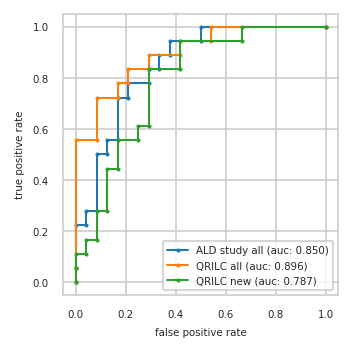

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.000 0.056
2          0.000 0.222     0.000 0.556     0.000 0.111
3          0.042 0.222     0.083 0.556     0.042 0.111
4          0.042 0.278     0.083 0.722     0.042 0.167
5          0.083 0.278     0.167 0.722     0.083 0.167
6          0.083 0.500     0.167 0.778     0.083 0.278
7          0.125 0.500     0.208 0.778     0.125 0.278
8          0.125 0.556     0.208 0.833     0.125 0.444
9          0.167 0.556     0.292 0.833     0.167 0.444
10         0.167 0.722     0.292 0.889     0.167 0.556
11         0.208 0.722     0.417 0.889     0.250 0.556
12         0.208 0.778     0.417 0.944     0.250 0.611
13         0.292 0.778     0.542 0.944     0.292 0.611
14         0.292 0.833     0.542 1.000     0.292 0.833
15         0.333 0.833     1.000 1.000     0.417 0.833
16         0.333 0.889       NaN   NaN     0.417 0.944
17         0.375 0.889       NaN   NaN     0.667 0.944
18         0.375 0.944       NaN   NaN     0.667 1.000
19         0.500 0.944       NaN   NaN     1.000 1.000
20         0.500 1.000       NaN   NaN       NaN   NaN
21         1.000 1.000       NaN   NaN       NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P04075,P10636-2;P10636-6,P10644;P10644-2
1,Q9NRN5,A0A0B4J1V0,P84157-2
2,P09486,B1AHL2;P23142-4,E7EN89;E9PP67;E9PQ25;F2Z2Y8;Q9H0E2;Q9H0E2-2
3,K7ERG9;P00746,Q9Y2T3;Q9Y2T3-3,D6R956;P09936
4,P10636-2;P10636-6,P61981,Q5R3F8
5,P14174,P15151-2,Q14894
6,P61981,P14174,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...
7,P18428,P04075,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
8,Q9Y2T3;Q9Y2T3-3,P63104,P31321


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


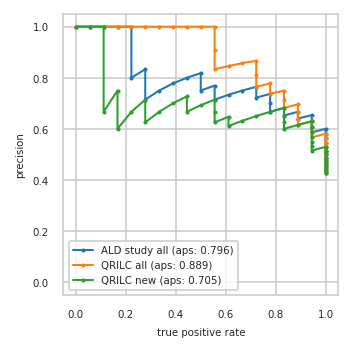

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.567 0.944     0.567 0.944
13         0.586 0.944     0.586 0.944     0.586 0.944
14         0.607 0.944     0.607 0.944     0.607 0.944
15         0.630 0.944     0.630 0.944     0.630 0.944
16         0.654 0.944     0.615 0.889     0.615 0.889
17         0.640 0.889     0.640 0.889     0.600 0.833
18         0.667 0.889     0.667 0.889     0.625 0.833
19         0.652 0.833     0.696 0.889     0.652 0.833
20         0.682 0.833     0.682 0.833     0.682 0.833
21         0.667 0.778     0.714 0.833     0.667 0.778
22         0.700 0.778     0.750 0.833     0.650 0.722
23         0.737 0.778     0.737 0.778     0.632 0.667
24         0.722 0.722     0.778 0.778     0.611 0.611
25         0.765 0.722     0.765 0.722     0.647 0.611
26         0.750 0.667     0.812 0.722     0.625 0.556
27         0.733 0.611     0.867 0.722     0.667 0.556
28         0.714 0.556     0.857 0.667     0.714 0.556
29         0.769 0.556     0.846 0.611     0.692 0.500
30         0.750 0.500     0.833 0.556     0.667 0.444
31         0.818 0.500     0.909 0.556     0.727 0.444
32         0.800 0.444     1.000 0.556     0.700 0.389
33         0.778 0.389     1.000 0.500     0.667 0.333
34         0.750 0.333     1.000 0.444     0.625 0.278
35         0.714 0.278     1.000 0.389     0.714 0.278
36         0.833 0.278     1.000 0.333     0.667 0.222
37         0.800 0.222     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


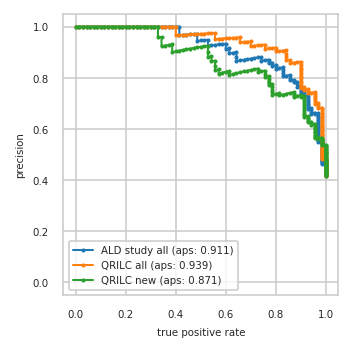

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


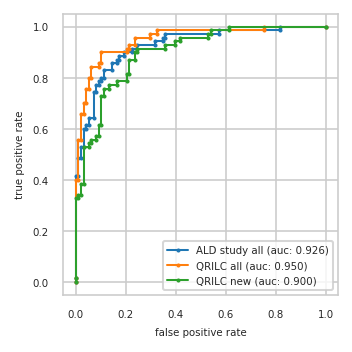

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}